# LIGO - Gravitational Waves Detectability

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\venv\Utilities")
from Utilities import plot_settings, Classify_vs

In [7]:
data_path = r"C:\Users\ricca\OneDrive\Documents\LIGO.h5"
data = h5py.File(data_path)

Read Data ('det' column is result $\to$ I'll ignore it)

In [8]:
def load_data(data_path):
    with h5py.File(data_path, 'r') as f:
        keys = [key for key in f.keys() if key != 'det']
        y = f['det'][()]
        data = {key: f[key][()] for key in keys}
        df = pd.DataFrame(data)
    return keys, y, data, df

def drop_nans(df, keys, y):
  # Drop rows with any NaNs
    df = df.dropna()
    # Apply same mask to arrays and y
    valid_indices = df.index
    arrays = [df[key].values for key in keys]
    y = y[valid_indices]
    return y, data, df, arrays

In [9]:
keys, y, data, df = load_data(data_path)

MemoryError: Unable to allocate 2.09 GiB for an array with shape (14, 20000000) and data type float64

In [6]:
y, data, df, arrays = drop_nans(df, keys, y)

In [3]:
X = np.array(arrays).T

MemoryError: Unable to allocate 2.09 GiB for an array with shape (14, 19999999) and data type float64

In [ ]:
joblib.dump(X, "X.pkl")

In [9]:
print('Data shape is ', X.shape)

Data shape is  (19999999, 14)


Lots of data, probably too many $\to$ downsample! But there is risk to lose information (variance). I will thus use KMeans to compute the number of clusters, cross validate on that number and use this number as my reduced dataset

## First Approach: random downsampling

In [12]:
downsampling_factor = 10000
batch_size = 1000
X_ds, y_ds = Classify_vs.downsample_by_factor(X, y, 10000)

AttributeError: module 'Utilities.Classify_vs' has no attribute 'downsample_by_factor'

In [11]:
X_ds.shape

(2907216, 14)

In [9]:
joblib.dump(X_ds, "X_ds.pkl")
joblib.dump(y_ds, "y_ds.pkl")

['y_ds.pkl']

Data have to be scaled!

In [10]:
X_ds.mean(axis=1)

array([31.10705748, 46.81828788, 45.9055432 , ..., 16.41213146,
       11.94600954, 66.96402329], shape=(5774432,))

# If already runned...start from HERE!

In [2]:
X_ds = joblib.load("X_ds.pkl")
y_ds = joblib.load("y_ds.pkl")

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
S = StandardScaler().fit_transform(X_ds)

## Dimensional Reduction: PCA

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(n_components=14)

In [7]:
T = pca.fit_transform(S)

In [8]:
pca.explained_variance_ratio_

array([0.07437312, 0.07339965, 0.07227408, 0.0716508 , 0.07157766,
       0.07152086, 0.07141402, 0.07129909, 0.07124982, 0.07120341,
       0.07114379, 0.07080625, 0.06988227, 0.06820518])

I'd say I cannot reduce the number of features here...

## Supervised Classification: Linear Discrimination Anaysis

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from Utilities.Classify_vs import evaluate_classifier_over_features, visualize_classification

In [10]:
(S_train, S_test, y_ds_train, y_ds_test) = train_test_split(S, y_ds, test_size=0.25, random_state=42)

Computing predictions on feature  1
Computing predictions on feature  2
Computing predictions on feature  3
Computing predictions on feature  4
Computing predictions on feature  5
Computing predictions on feature  6
Computing predictions on feature  7
Computing predictions on feature  8
Computing predictions on feature  9
Computing predictions on feature  10
Computing predictions on feature  11
Computing predictions on feature  12
Computing predictions on feature  13
Computing predictions on feature  14
Computing completeness, contamination...
Plotting ROC...


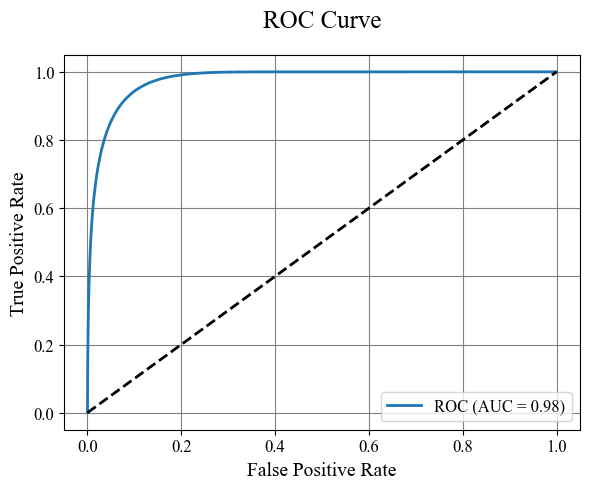

In [ ]:
result = evaluate_classifier_over_features(S_train, S_test, y_ds_train, y_ds_test, LDA(), ROC=True)

In [18]:
joblib.dump(result, "LDA_result.pkl")

['LDA_result.pkl']

In [11]:
result = joblib.load("LDA_result.pkl")

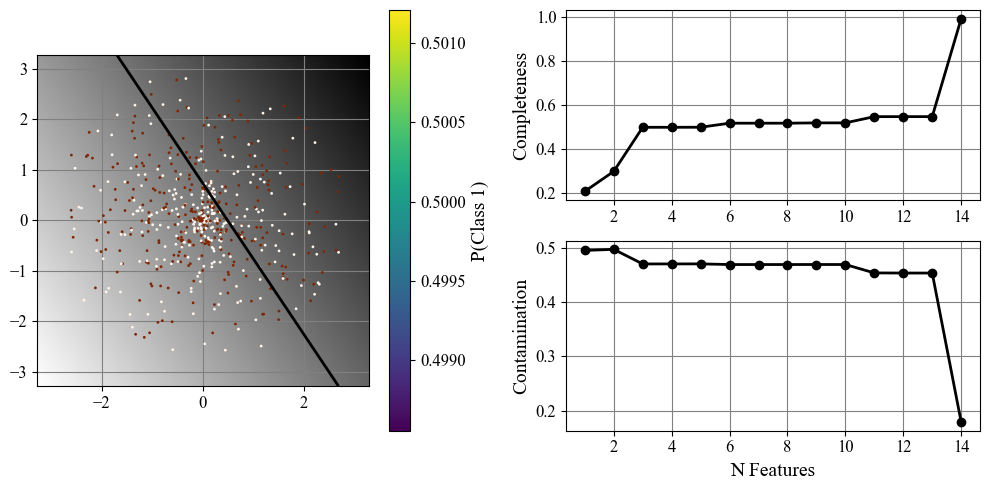

In [12]:
visualize_classification(S, y_ds, result['classifiers'][1], result['completeness'], result['contamination'], f=10000)

## GMM - Bayes 

In [5]:
from astroML.classification import GMMBayes as GMB
from Utilities.Classify_vs import evaluate_gmm_classifier, cross_validate_gmm_components

In [6]:
best_n, scores = cross_validate_gmm_components(S, y_ds, GMB, [2, 20, 200])

Performing CV on 2 components
Performing CV on 20 components


KeyboardInterrupt: 

In [ ]:
result = evaluate_gmm_classifier(S_train, S_test, y_ds_train, y_ds_test, GMB, 20, True)

NameError: name 'evaluate_classifier_over_features' is not defined

## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [ ]:
result = evaluate_classifier_over_features(S_train, S_test, y_ds_train, y_ds_test, RFC(), ROC=True)

Computing predictions on feature  1
